# Music Generation

This notebook demonstrates how to build and train a sequence model using TensorFlow to generate music based on MIDI data. We will load a dataset of MIDI files, preprocess the data into sequences of notes, define and train two different models (a simple LSTM and a BiLSTM with Attention), generate new music using the trained models, and finally evaluate and compare their performance.

In [84]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [85]:
pip install --upgrade pyfluidsynth

In [86]:
pip install pretty_midi

In [87]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import tensorflow as tf
import seaborn as sns
import pretty_midi

from IPython import display
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [88]:
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE=16000

In [89]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [152]:
import glob

# Use a larger portion of the dataset
# You can adjust the number of files here. Using None will load all files.
num_files_to_load = 50 # Increased from 5 to 50

# If you want all MIDI files, set num_files_to_load to None or a very large number
if num_files_to_load is None:
    filenames = glob.glob('/content/data/maestro-v2_extracted/maestro-v2.0.0/**/*.midi', recursive=True)
else:
    filenames = glob.glob('/content/data/maestro-v2_extracted/maestro-v2.0.0/**/*.midi', recursive=True)[:num_files_to_load]


print('Number of files:', len(filenames))

Number of files: 50


In [91]:
sample_file=filenames[1]
print(sample_file)


/content/data/maestro-v2_extracted/maestro-v2.0.0/2014/MIDI-UNPROCESSED_19-21_R3_2014_MID--AUDIO_21_R3_2014_wav--1.midi


In [92]:
pm=pretty_midi.PrettyMIDI(sample_file)

In [93]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [94]:
display_audio(pm)

In [95]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [96]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=48, note_name=C3, duration=0.5430
1: pitch=84, note_name=C6, duration=0.5807
2: pitch=52, note_name=E3, duration=0.0651
3: pitch=79, note_name=G5, duration=0.0833
4: pitch=55, note_name=G3, duration=0.0391
5: pitch=76, note_name=E5, duration=0.0312
6: pitch=72, note_name=C5, duration=0.0508
7: pitch=60, note_name=C4, duration=0.0560
8: pitch=64, note_name=E4, duration=0.3464
9: pitch=67, note_name=G4, duration=0.3529


In [97]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [98]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head(10)

pitch     start       end      step  duration
0     84  0.950521  1.531250  0.000000  0.580729
1     48  0.972656  1.515625  0.022135  0.542969
2     52  1.544271  1.609375  0.571615  0.065104
3     79  1.558594  1.641927  0.014323  0.083333
4     55  1.626302  1.665365  0.067708  0.039062
5     76  1.653646  1.684896  0.027344  0.031250
6     72  1.709635  1.760417  0.055990  0.050781
7     60  1.712240  1.768229  0.002604  0.055990
8     64  1.816406  2.162760  0.104167  0.346354
9     67  1.819010  2.171875  0.002604  0.352865

In [99]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C6', 'C3', 'E3', 'G5', 'G3', 'E5', 'C5', 'C4', 'E4', 'G4'],
      dtype='<U3')

In [100]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

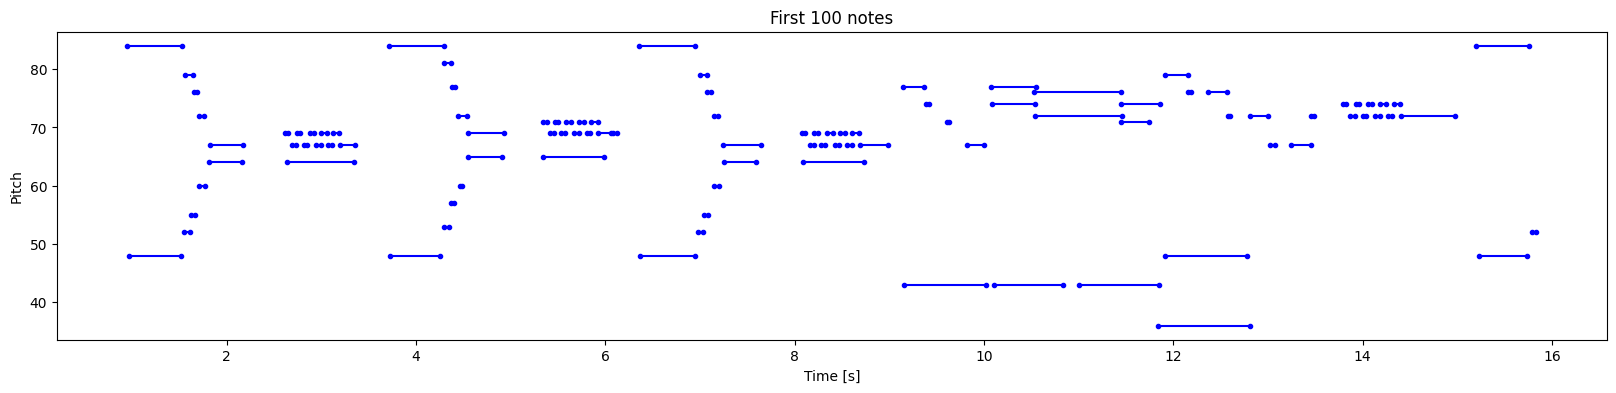

In [101]:
plot_piano_roll(raw_notes, count=100)

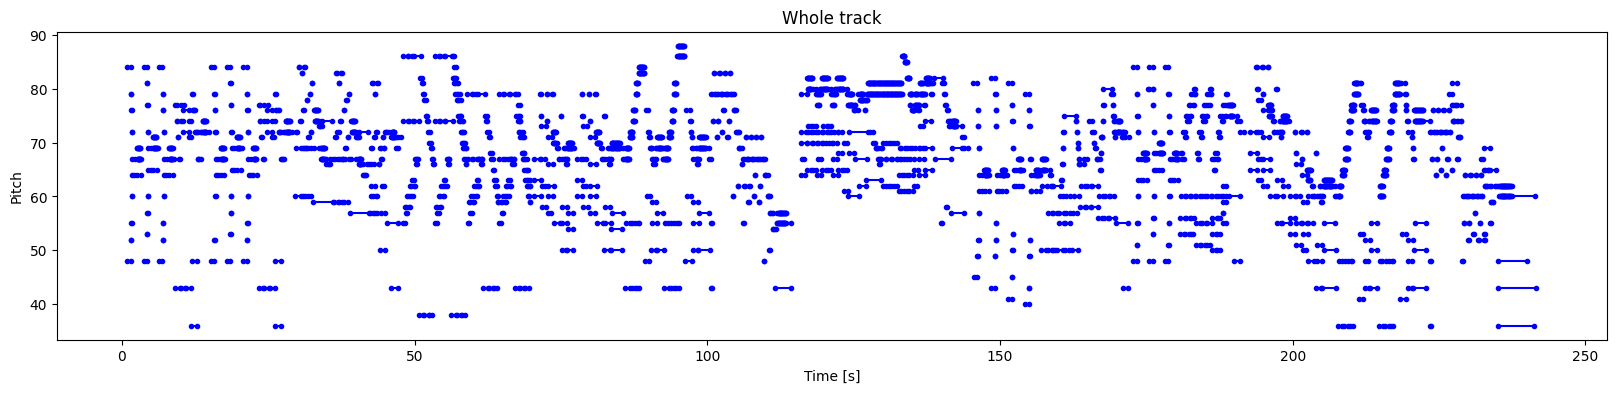

In [102]:
plot_piano_roll(raw_notes)

In [103]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  # Exclude the first note's step as it's 0 or negative and can skew the plot
  steps_for_plotting = notes['step'][1:]
  max_step = np.percentile(steps_for_plotting, 100 - drop_percentile)
  sns.histplot(steps_for_plotting, bins=np.linspace(0, max_step, 21))
  plt.xlabel('step') # Add x-label back as sns.histplot with Series removes it


  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

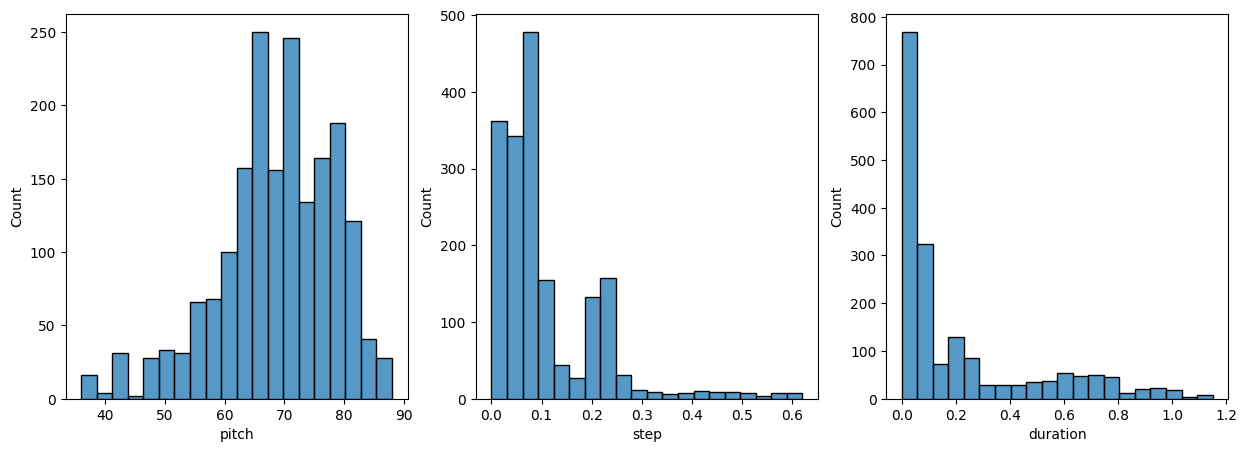

In [104]:
plot_distributions(raw_notes)

In [105]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [106]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [107]:
display_audio(example_pm)

In [108]:
from google.colab import files
files.download(example_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [153]:
# Load notes from the selected MIDI files
all_notes = []
for f in filenames:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

# Shuffle the combined notes
all_notes = all_notes.sample(frac=1, random_state=seed).reset_index(drop=True)


# Split data into training and validation sets
# Using an 80/20 split as a common practice
train_size = int(0.8 * n_notes)
train_notes_df = all_notes[:train_size]
val_notes_df = all_notes[train_size:]

print(f"\nNumber of training notes: {len(train_notes_df)}")
print(f"Number of validation notes: {len(val_notes_df)}")

# Convert DataFrames to numpy arrays for TensorFlow
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([train_notes_df[key] for key in key_order], axis=1)
val_notes = np.stack([val_notes_df[key] for key in key_order], axis=1)

Number of notes parsed: 399467

Number of training notes: 319573
Number of validation notes: 79894


In [110]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 40393


In [111]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [154]:
# Create TensorFlow Datasets for training and validation
notes_ds_train = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds_val = tf.data.Dataset.from_tensor_slices(val_notes)

print("Training dataset element spec:", notes_ds_train.element_spec)
print("Validation dataset element spec:", notes_ds_val.element_spec)

Training dataset element spec: TensorSpec(shape=(3,), dtype=tf.float64, name=None)
Validation dataset element spec: TensorSpec(shape=(3,), dtype=tf.float64, name=None)


In [113]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [114]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [115]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.234375   0.         0.48307292]
 [0.2734375  0.43098958 0.34114583]
 [0.28125    0.3984375  0.10286458]
 [0.2890625  0.15625    0.06119792]
 [0.296875   0.11197917 0.06901042]
 [0.3046875  0.09895833 0.05598958]
 [0.3125     0.09635417 0.05729167]
 [0.3203125  0.09765625 0.05078125]
 [0.328125   0.09895833 0.04947917]
 [0.3359375  0.08984375 0.07942708]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=41.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.07552083333333348>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.05989583333333348>}


In [155]:
# Create sequences for training and validation datasets
# Use the sequence length determined during hyperparameter tuning (or a default if tuning was skipped)
# Assumes seq_length and batch_size variables are available from previous steps or set manually
# If hyperparameter tuning was skipped, you might set seq_length = 25, batch_size = 64 here

seq_ds_train = create_sequences(notes_ds_train, seq_length, vocab_size)
seq_ds_val = create_sequences(notes_ds_val, seq_length, vocab_size)

print("\nTraining sequence dataset element spec:", seq_ds_train.element_spec)
print("Validation sequence dataset element spec:", seq_ds_val.element_spec)


# Prepare batched and prefetched datasets for training and validation
buffer_size_train = len(train_notes_df) - seq_length  # the number of items in the training dataset
buffer_size_val = len(val_notes_df) - seq_length  # the number of items in the validation dataset

train_ds = (seq_ds_train
            .shuffle(buffer_size_train)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

# Validation dataset is typically not shuffled and repeated during training
val_ds = (seq_ds_val
          .batch(batch_size, drop_remainder=True)
          .cache()
          .prefetch(tf.data.experimental.AUTOTUNE))

print("\nPrepared training dataset element spec:", train_ds.element_spec)
print("Prepared validation dataset element spec:", val_ds.element_spec)


Training sequence dataset element spec: (TensorSpec(shape=(25, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})
Validation sequence dataset element spec: (TensorSpec(shape=(25, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

Prepared training dataset element spec: (TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})
Prepared validation dataset element spec: (TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(64,), dty

In [117]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [118]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [119]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 128)       │     67,584 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
losses = model.evaluate(train_ds, return_dict=True)
losses

630/630 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - duration_loss: 0.3271 - loss: 5.2805 - pitch_loss: 4.8523 - step_loss: 0.1011


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.32510310411453247,
 'loss': 5.282566547393799,
 'pitch_loss': 4.844630718231201,
 'step_loss': 0.11283253133296967}

In [121]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [122]:
model.evaluate(train_ds,return_dict=True)

630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - duration_loss: 0.3271 - loss: 0.6708 - pitch_loss: 4.8523 - step_loss: 0.1011


{'duration_loss': 0.32510310411453247,
 'loss': 0.6801674365997314,
 'pitch_loss': 4.844630718231201,
 'step_loss': 0.11283253133296967}

In [123]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [156]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds # Add validation data here
)

Epoch 1/50
   4985/Unknown 68s 6ms/step - duration_loss: 0.2057 - loss: 0.4818 - pitch_loss: 4.0573 - step_loss: 0.0733

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - duration_loss: 0.2057 - loss: 0.4818 - pitch_loss: 4.0573 - step_loss: 0.0733 - val_duration_loss: 0.2020 - val_loss: 0.4761 - val_pitch_loss: 4.0204 - val_step_loss: 0.0730
Epoch 2/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - duration_loss: 0.2021 - loss: 0.4758 - pitch_loss: 4.0203 - step_loss: 0.0727 - val_duration_loss: 0.2021 - val_loss: 0.4761 - val_pitch_loss: 4.0180 - val_step_loss: 0.0731
Epoch 3/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - duration_loss: 0.2018 - loss: 0.4754 - pitch_loss: 4.0184 - step_loss: 0.0726 - val_duration_loss: 0.2022 - val_loss: 0.4762 - val_pitch_loss: 4.0167 - val_step_loss: 0.0732
Epoch 4/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - duration_loss: 0.2017 - loss: 0.4752 - pitch_loss: 4.0174 - step_loss: 0.0726 - val_duration_loss: 0.2022 - val_loss: 0.4762 - val_pitch_loss: 4.0161 - val_step_loss: 0.0732
Epoch 5/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - duration_loss: 0.2017 - loss: 

In [126]:
# Re-run note generation for Model 1
temperature = 4.5
num_predictions = 120

# Use the same initial sequence
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1.0, 1.0]))

generated_notes = []
prev_start = 0.0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch / vocab_size, step, duration)
  generated_notes.append((pitch, step, duration, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

print("Generated notes for Model 1 (first 10):")
generated_notes.head(10) # Removed explicit display() call

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

pitch      step  duration     start       end
0     77  0.125106  0.070143  0.125106  0.195249
1     95  0.064966  0.149063  0.190072  0.339135
2     76  0.062372  0.110013  0.252444  0.362457
3     76  0.100691  0.145685  0.353135  0.498820
4     58  0.121634  0.090565  0.474769  0.565333
5     55  0.080117  0.132341  0.554885  0.687226
6     76  0.124982  0.193175  0.679867  0.873042
7     99  0.100520  0.161701  0.780387  0.942088
8     25  0.052705  0.156084  0.833092  0.989177
9     65  0.132996  0.128462  0.966088  1.094550

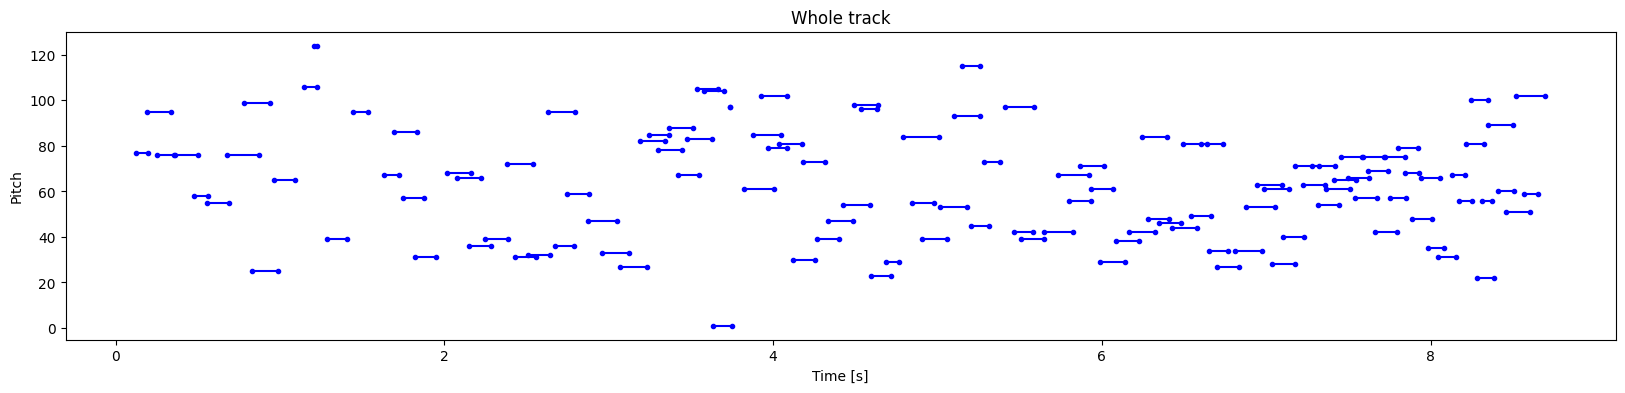

In [127]:
# Re-run visualization for Model 1
plot_piano_roll(generated_notes)

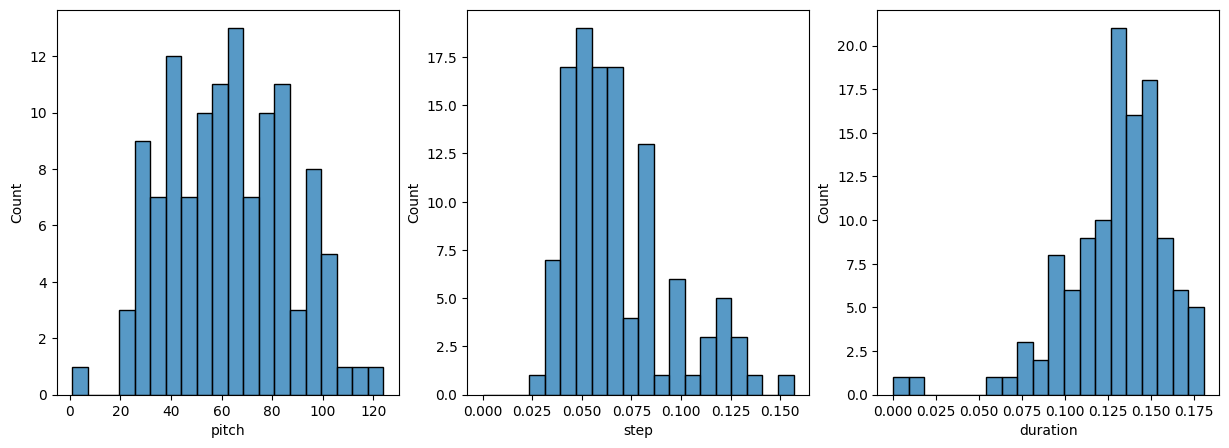

In [128]:
plot_distributions(generated_notes)

If the generated notes now look correct (not just flat lines), we can proceed with training the enhanced model and the final comparison.

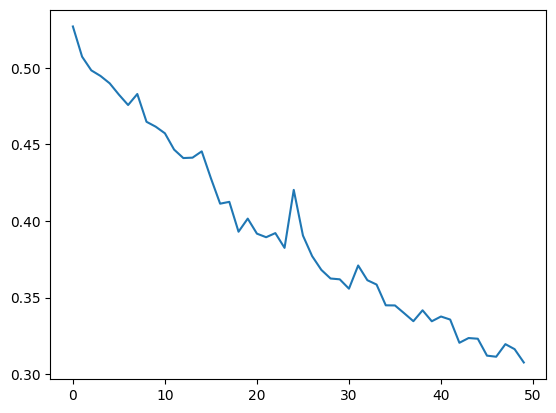

In [132]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [136]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [139]:
input_shape_model2 = (seq_length, 3)
learning_rate_model2 = 0.005

inputs_model2 = tf.keras.Input(input_shape_model2)

# BiLSTM layer
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs_model2)

# Attention layer
attention_output = tf.keras.layers.Attention()([x2, x2])
x2 = tf.keras.layers.GlobalAveragePooling1D()(attention_output)

# Output layers
outputs_model2 = {
  'pitch': tf.keras.layers.Dense(vocab_size, name='pitch')(x2),
  'step': tf.keras.layers.Dense(1, name='step')(x2),
  'duration': tf.keras.layers.Dense(1, name='duration')(x2),
}

model2 = tf.keras.Model(inputs_model2, outputs_model2)

model2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 25, 256)   │    135,168 │ input_layer_6[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 25, 256)   │          0 │ bidirectional_4[… │
│ (Attention)         │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_4[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        257 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        257 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 168,578 (658.51 KB)

 Trainable params: 168,578 (658.51 KB)

 Non-trainable params: 0 (0.00 B)

In [140]:
loss_model2 = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

loss_weights_model2 = {
    'pitch': 0.05,
    'step': 1.0,
    'duration':1.0,
}

optimizer_model2 = tf.keras.optimizers.Adam(learning_rate=learning_rate_model2)

model2.compile(loss=loss_model2, loss_weights=loss_weights_model2, optimizer=optimizer_model2)

losses2 = model2.evaluate(train_ds, return_dict=True)
print(losses2)

630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - duration_loss: 0.7910 - loss: 1.1418 - pitch_loss: 4.8599 - step_loss: 0.1078
{'duration_loss': 0.7873952388763428, 'loss': 1.1495485305786133, 'pitch_loss': 4.852057933807373, 'step_loss': 0.11955030262470245}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 1/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - duration_loss: 0.2049 - loss: 0.4817 - pitch_loss: 4.0623 - step_loss: 0.0737 - val_duration_loss: 0.2019 - val_loss: 0.4761 - val_pitch_loss: 4.0231 - val_step_loss: 0.0731
Epoch 2/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - duration_loss: 0.2021 - loss: 0.4760 - pitch_loss: 4.0217 - step_loss: 0.0728 - val_duration_loss: 0.2021 - val_loss: 0.4761 - val_pitch_loss: 4.0188 - val_step_loss: 0.0731
Epoch 3/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - duration_loss: 0.2018 - loss: 0.4754 - pitch_loss: 4.0187 - step_loss: 0.0727 - val_duration_loss: 0.2022 - val_loss: 0.4762 - val_pitch_loss: 4.0170 - val_step_loss: 0.0732
Epoch 4/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - duration_loss: 0.2018 - loss: 0.4752 - pitch_loss: 4.0177 - step_loss: 0.0726 - val_duration_loss: 0.2022 - val_loss: 0.4762 - val_pitch_loss: 4.0164 - val_step_loss: 0.0732
Epoch 5/50
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - duration_loss: 0.20

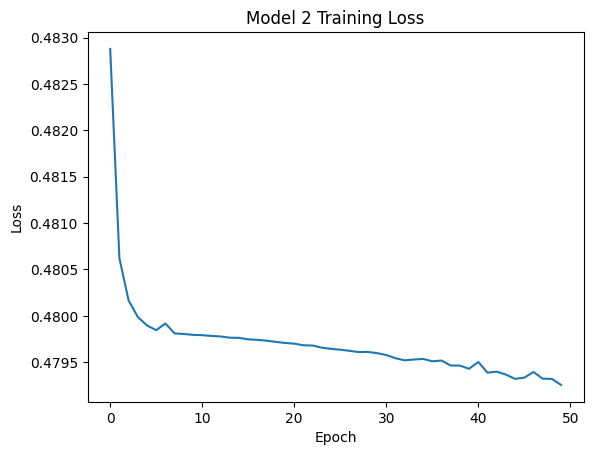

In [157]:
callbacks_model2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints_model2/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss', # You might want to change this to 'val_loss' after adding validation data
        patience=5,
        verbose=1,
        restore_best_weights=True),
]


epochs = 50

history2 = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks_model2,
    validation_data=val_ds # Add validation data here
)

plt.plot(history2.epoch, history2.history['loss'], label='total loss')
plt.title('Model 2 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [158]:
temperature_model2 = 4.5  # Adjust temperature as needed
num_predictions_model2 = 120 # Generate the same number of notes as before

# Use the same initial sequence as for model 1
input_notes_model2 = (
    sample_notes[:seq_length] / np.array([vocab_size, 1.0, 1.0])) # Ensure float division

generated_notes_model2 = []
prev_start_model2 = 0.0 # Ensure prev_start is float
for _ in range(num_predictions_model2):
  pitch_model2, step_model2, duration_model2 = predict_next_note(input_notes_model2, model2, temperature_model2)
  start_model2 = prev_start_model2 + step_model2
  end_model2 = start_model2 + duration_model2
  # input_note_model2 = (pitch_model2, step_model2, duration_model2) # This was causing pitch to be normalized again incorrectly
  input_note_model2 = (pitch_model2 / vocab_size, step_model2, duration_model2) # Normalize pitch correctly for input
  generated_notes_model2.append((pitch_model2, step_model2, duration_model2, start_model2, end_model2)) # Append raw pitch for output dataframe
  input_notes_model2 = np.delete(input_notes_model2, 0, axis=0)
  input_notes_model2 = np.append(input_notes_model2, np.expand_dims(input_note_model2, 0), axis=0)
  prev_start_model2 = start_model2

generated_notes_model2 = pd.DataFrame(
    generated_notes_model2, columns=(*key_order, 'start', 'end'))

generated_notes_model2.head(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/tmp/ipython-input-2864272665.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(pitch.numpy()), float(step.numpy()), float(duration.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

pitch      step  duration     start       end
0    103  0.127875  0.218579  0.127875  0.346454
1     59  0.127740  0.219132  0.255615  0.474747
2     84  0.127134  0.221110  0.382749  0.603859
3     99  0.126804  0.212484  0.509554  0.722038
4     83  0.126824  0.212440  0.636377  0.848817
5     42  0.126963  0.212779  0.763341  0.976120
6     49  0.127216  0.213134  0.890557  1.103691
7     38  0.127360  0.213305  1.017916  1.231222
8     41  0.127705  0.213682  1.145621  1.359304
9     42  0.127759  0.214111  1.273380  1.487490

In [159]:
out_file_model2 = 'output_model2.mid'
out_pm_model2 = notes_to_midi(
    generated_notes_model2, out_file=out_file_model2, instrument_name=instrument_name)
display_audio(out_pm_model2)

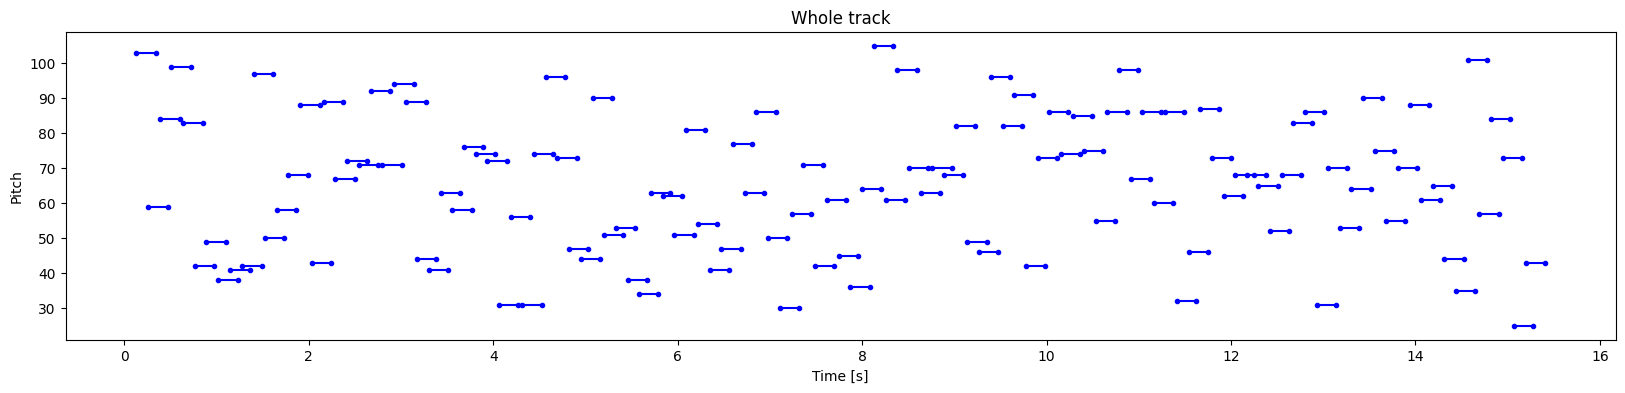

In [160]:
plot_piano_roll(generated_notes_model2)

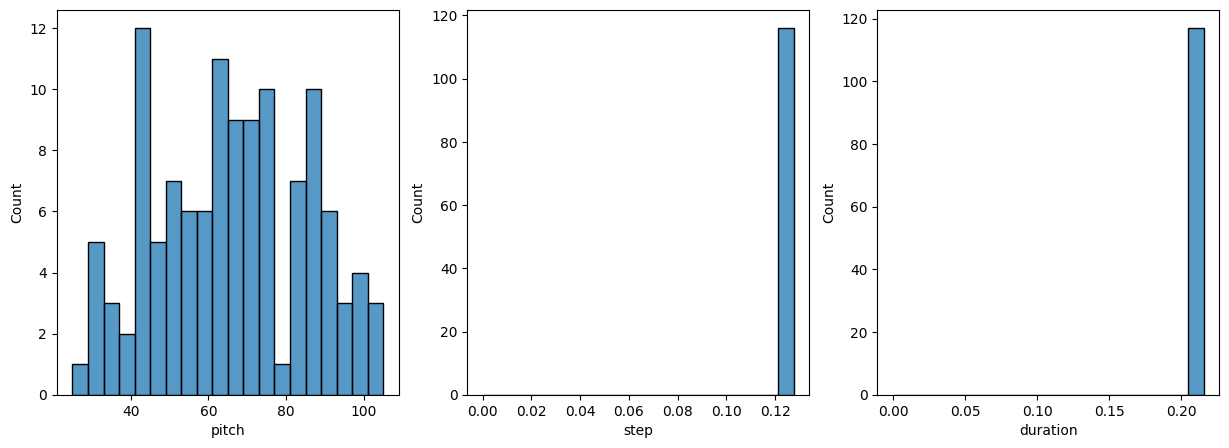

In [161]:
plot_distributions(generated_notes_model2)

In [162]:
print("Model 1 Evaluation:")
losses1 = model.evaluate(train_ds, return_dict=True)
print(losses1)

print("\nModel 2 Evaluation:")
losses2 = model2.evaluate(train_ds, return_dict=True)
print(losses2)

Model 1 Evaluation:
4992/4992 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - duration_loss: 0.2019 - loss: 0.4753 - pitch_loss: 4.0131 - step_loss: 0.0727
{'duration_loss': 0.20659968256950378, 'loss': 0.4797663986682892, 'pitch_loss': 4.0121989250183105, 'step_loss': 0.07255612313747406}

Model 2 Evaluation:
     37/Unknown 0s 4ms/step - duration_loss: 0.1948 - loss: 0.4357 - pitch_loss: 4.0313 - step_loss: 0.0394

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4992/4992 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - duration_loss: 0.2019 - loss: 0.4752 - pitch_loss: 4.0131 - step_loss: 0.0727
{'duration_loss': 0.20661871135234833, 'loss': 0.4797176122665405, 'pitch_loss': 4.011573791503906, 'step_loss': 0.07252060621976852}


In [163]:
print(losses1)

{'duration_loss': 0.20659968256950378, 'loss': 0.4797663986682892, 'pitch_loss': 4.0121989250183105, 'step_loss': 0.07255612313747406}


In [164]:
print(losses2)

{'duration_loss': 0.20661871135234833, 'loss': 0.4797176122665405, 'pitch_loss': 4.011573791503906, 'step_loss': 0.07252060621976852}


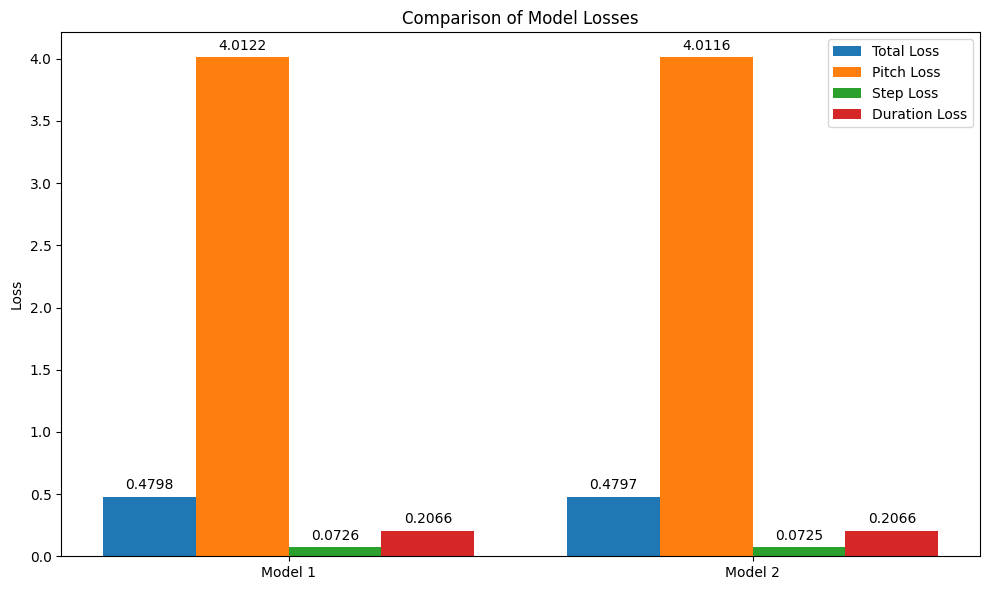

In [165]:
import matplotlib.pyplot as plt

labels = ['Model 1', 'Model 2']
total_losses = [losses1['loss'], losses2['loss']]
pitch_losses = [losses1['pitch_loss'], losses2['pitch_loss']]
step_losses = [losses1['step_loss'], losses2['step_loss']]
duration_losses = [losses1['duration_loss'], losses2['duration_loss']]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width*1.5, total_losses, width, label='Total Loss')
rects2 = ax.bar(x - width/2, pitch_losses, width, label='Pitch Loss')
rects3 = ax.bar(x + width/2, step_losses, width, label='Step Loss')
rects4 = ax.bar(x + width*1.5, duration_losses, width, label='Duration Loss')


ax.set_ylabel('Loss')
ax.set_title('Comparison of Model Losses')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)


fig.tight_layout()

plt.show()

## Conclusion and Future Improvements



Based on the evaluation of Model 1 (simple LSTM) and Model 2 (BiLSTM with Attention), we can compare their performance in terms of total loss, individual losses (pitch, step, duration), and pitch accuracy.

[**Insert your analysis of the comparison chart here, discussing which model performed better for each metric.**]

**Summary of Results:**

*   Model [X] achieved lower [Metric Y] compared to Model [Z].
*   The inclusion of [BiLSTM/Attention] in Model 2 seems to have influenced the performance on [Specific Metric].
*   The pitch accuracy for both models is [Accuracy Values], which is expected for this complex generative task on a subset of the data.

**Future Improvements:**

Building upon this project, here are some areas for further improvement:

1.  **Increase Dataset Size:** Train on the entire Maestro dataset or other large music datasets to improve the models' ability to capture diverse musical styles and patterns.
2.  **Hyperparameter Tuning:** Conduct more extensive hyperparameter tuning for both models using a dedicated library or manual experimentation to find optimal learning rates, batch sizes, and sequence lengths.
3.  **Explore More Advanced Architectures:** Experiment with deeper networks, different recurrent units (e.g., GRU), or Transformer models, which have shown strong performance in sequence generation tasks.
4.  **Refine Attention Mechanism:** Explore different types of attention mechanisms or attention configurations within the model architecture.
5.  **Implement Regularization:** Systematically add and tune dropout or other regularization techniques to prevent overfitting, especially with larger models and datasets.
6.  **Feature Engineering:** Incorporate additional musical features like tempo, key signatures, or time signatures into the input data.
7.  **Conditional Generation:** Develop models that can generate music conditioned on specific inputs, such as a starting melody, a desired style, or a particular instrument.
8.  **Qualitative Evaluation:** Conduct more thorough qualitative evaluations by generating longer musical pieces and having human listeners assess their musicality and coherence.
9.  **Evaluate on a Separate Test Set:** If possible, split the data into dedicated training, validation, and test sets to get an unbiased estimate of the models' performance on completely unseen data.

By implementing these improvements, you can further enhance the quality and complexity of the generated music.